In [15]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='make_profiles',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 
cluster.scale(140)
cluster

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


In [16]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://172.30.100.4:44592 Dashboard: http://172.30.100.4:36913/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [17]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           8226604     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8226605     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8226606     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8226607     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8226608     hsw24 make_pro albert7a PD       0:00      1 (Resources)


In [18]:
import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

67


In [19]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           8226608     hsw24 make_pro albert7a PD       0:00      1 (Resources)
           8226609     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8226610     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8226611     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8226612     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8226613     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8226607     hsw24 make_pro albert7a  R       0:02      1 n2727
           8226604     hsw24 make_pro albert7a  R       0:51      1 n2652
           8226605     hsw24 make_pro albert7a  R       0:51      1 n2653
           8226606     hsw24 make_pro albert7a  R       0:51      1 n2655


In [20]:
import os
import sys
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean
import glob

%matplotlib inline


In [21]:
#params

plot_eke_monthly=False
plot_eke_annual=True


In [22]:
config='NACHOS12.L75'
case='MAA4002'
freq='1d'
year='2010'

#!ls $datadir
gridfile='/scratch/cnt0024/hmg2840/albert7a/NACHOS12.L75/NACHOS12.L75-I/NACHOS12.L75_coordinates.nc'
maskfile='/scratch/cnt0024/hmg2840/albert7a/NACHOS12.L75/NACHOS12.L75-I/NACHOS12.L75_MAA40_mesh_mask.nc'

In [23]:
dsgrid=xr.open_dataset(gridfile)
dsmask=xr.open_dataset(maskfile)

In [24]:
def compute_TKE(u2mean,v2mean):
    ua=0.5*(u2mean+u2mean.shift(x=1))
    va=0.5*(v2mean+v2mean.shift(y=1))
    uat=ua.rename({'depthu':'deptht'})
    vat=va.rename({'depthv':'deptht'})
    tke=0.5*(uat+vat)
    return tke


In [25]:
month_name={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
def plot_one_month(var,mask,vmin,vmax,cmap,title,figfile,month,year):
    fig, ax = plt.subplots(1,1,figsize=(10,15))
    var.where(mask==1).plot(cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,add_labels=True)
    ax.set_title(month_name[month])
    fig.suptitle('Monthly mean of '+str(title))
    plt.savefig('Plots/'+config+'/Maps/EU/'+config+'-'+case+'y'+str(year)+'m'+str(month)+'_'+figfile+'.png')

In [ ]:
def plot_one_year(var,mask,vmin,vmax,cmap,title,figfile,year):
    fig, ax = plt.subplots(1,1,figsize=(10,15))
    var.where(mask==1).plot(cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,add_labels=True)
    ax.set_title(config+'-'+case)
    fig.suptitle('Yearly mean of '+str(title))
    plt.savefig('Plots/'+config+'/Maps/EU/'+config+'-'+case+'y'+str(year)+'_'+figfile+'.png')

In [26]:
def process(year):
    datadir='/scratch/cnt0024/hmg2840/albert7a/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'+str(year)+'/'
    filesU=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridU.nc'))
    filesV=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridV.nc'))
    dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':10,'depthu':1})
    dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':10,'depthv':1})
    u=dsU.vozocrtx[:,:,651:1224,970:1213]
    v=dsV.vomecrty[:,:,651:1224,970:1213]
    mask=dsmask.tmask[0,:,651:1224,970:1213]
    u2=u*u
    v2=v*v
    u2mean=u2.mean(dim='time_counter')
    v2mean=v2.mean(dim='time_counter')
    umonth=u.groupby('time_counter.month').mean('time_counter')
    vmonth=v.groupby('time_counter.month').mean('time_counter')
    umonth2=umonth*umonth
    vmonth2=vmonth*vmonth
    tke=compute_TKE(umonth2,vmonth2)
    for m in np.arange(1,13):
        if not os.path.exists('Plots/'+config+'/Maps/EU/'+config+'-'+case+'y'+str(year)+'m'+str(m)+'_tke_surf.png'):
            print('Plotting for month '+str(m))
            plot_one_month(10000*tke[m-1,0],mask[0],0,2500,'cmo.amp','Surface TKE y'+year,'tke_surf',m,year)
   

2011
Plotting for month 1
Plotting for month 2
Plotting for month 3
Plotting for month 4
Plotting for month 5
Plotting for month 6
Plotting for month 7
Plotting for month 8
Plotting for month 9
Plotting for month 10
Plotting for month 11
Plotting for month 12
2012
Plotting for month 1
Plotting for month 2
Plotting for month 3
Plotting for month 4
Plotting for month 5


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Plotting for month 6
Plotting for month 7


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Plotting for month 8
Plotting for month 9


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Plotting for month 10


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Plotting for month 11


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Plotting for month 12


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


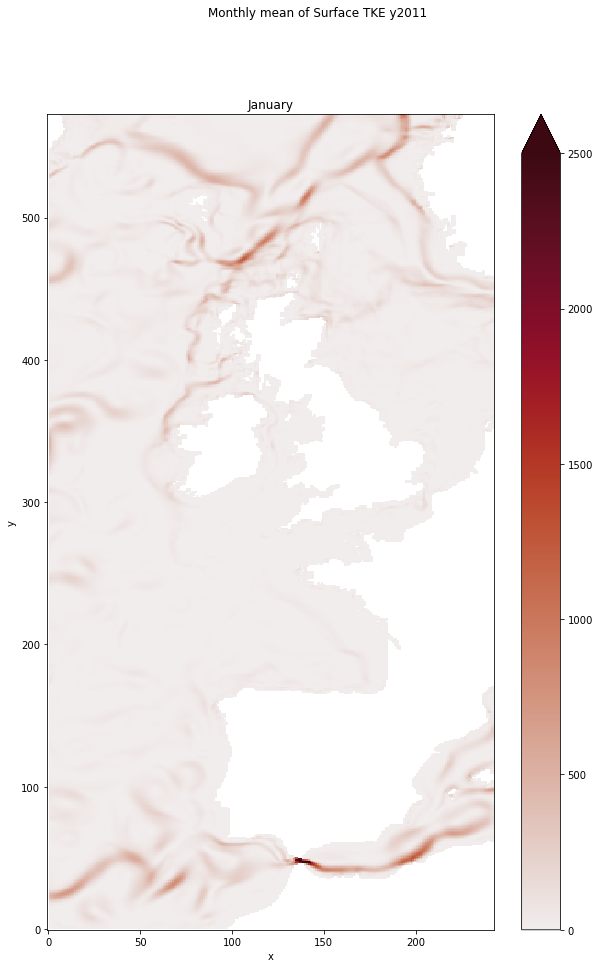

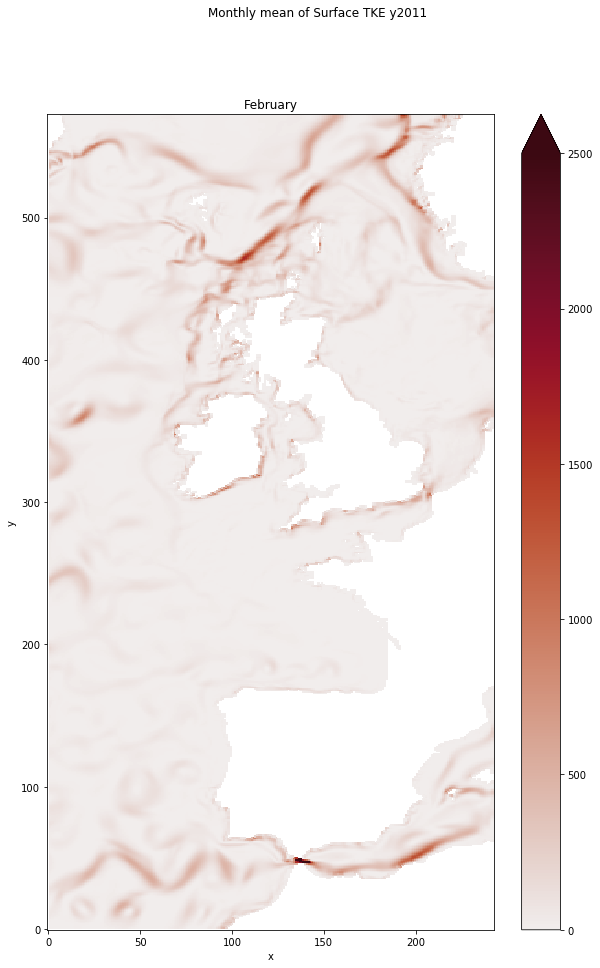

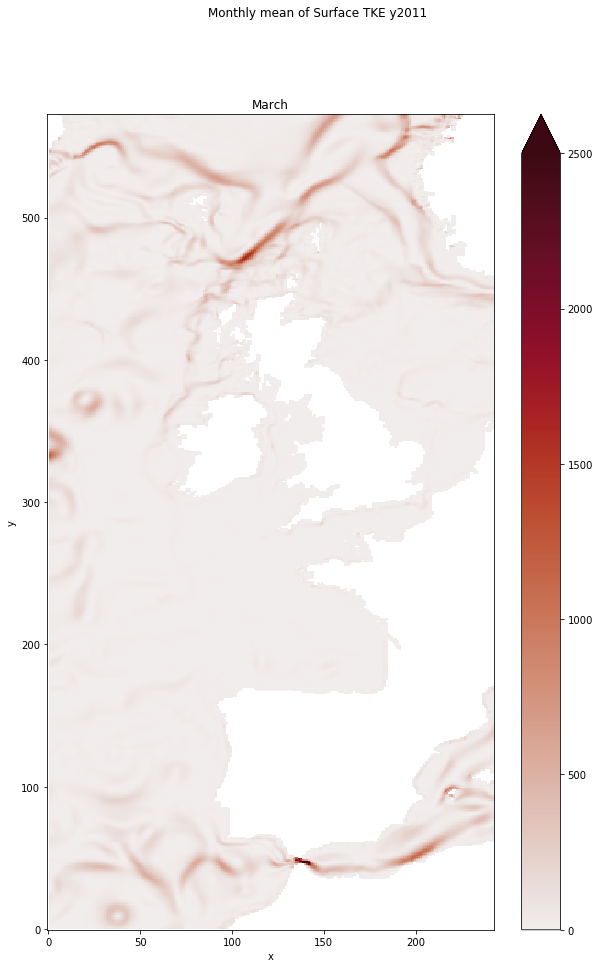

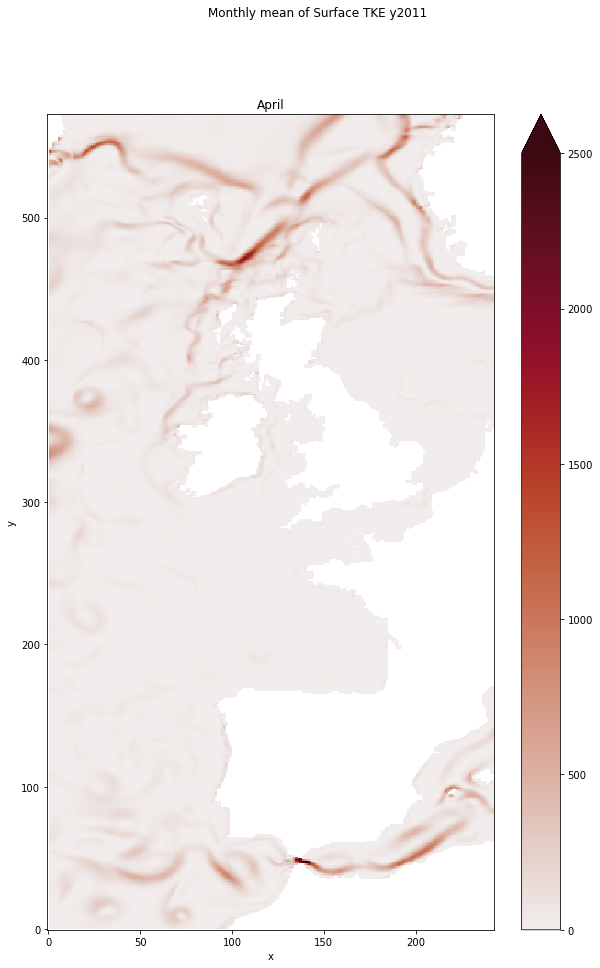

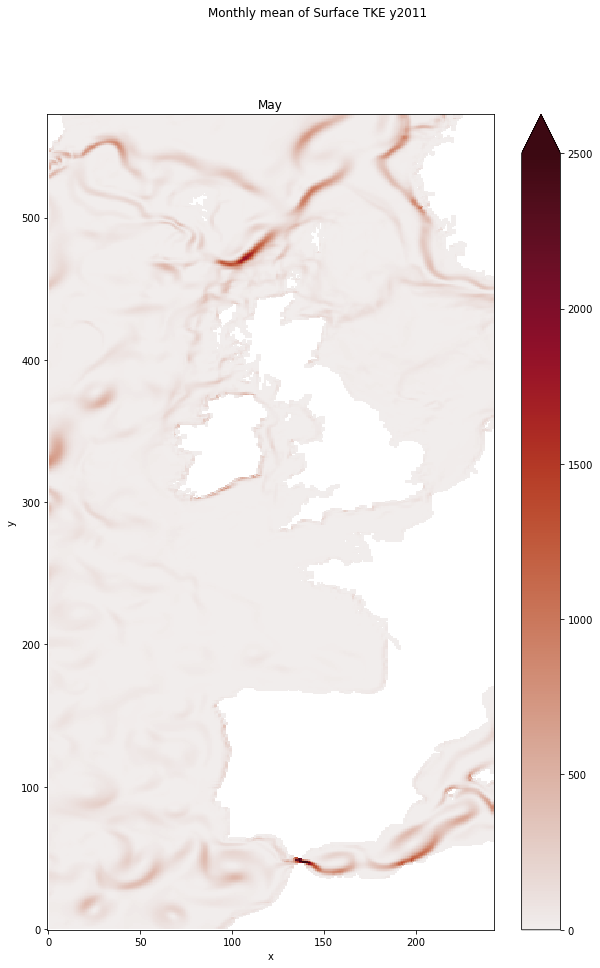

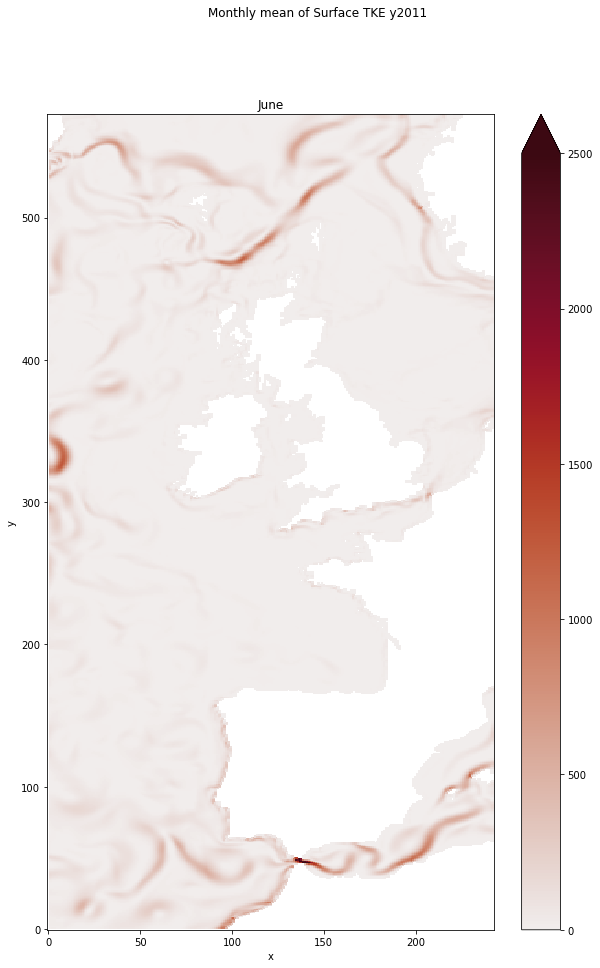

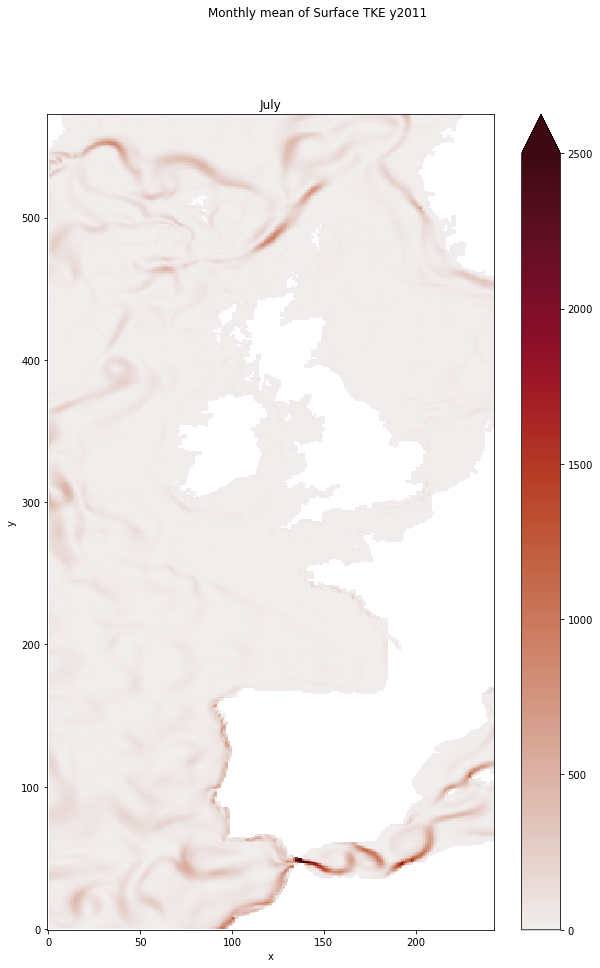

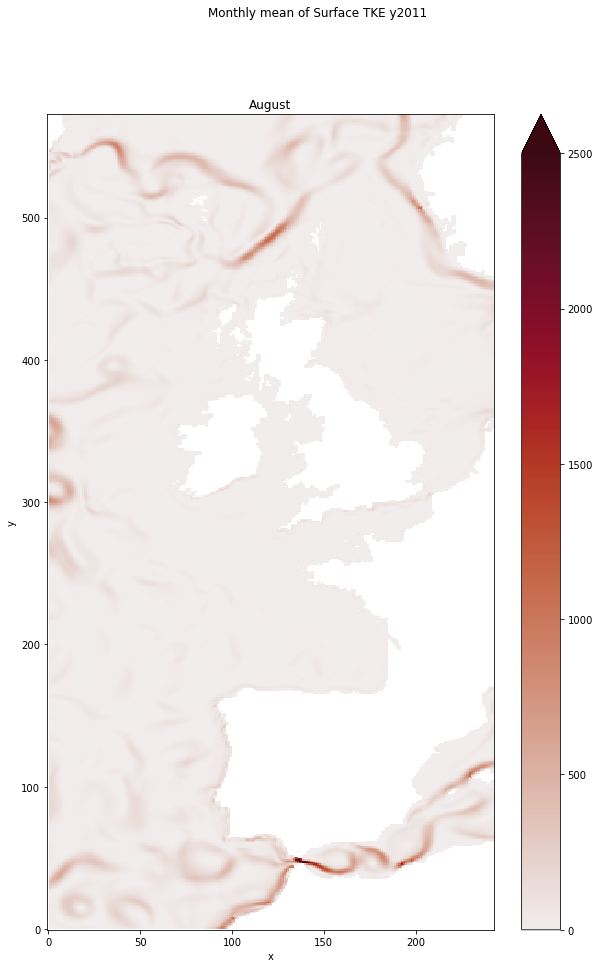

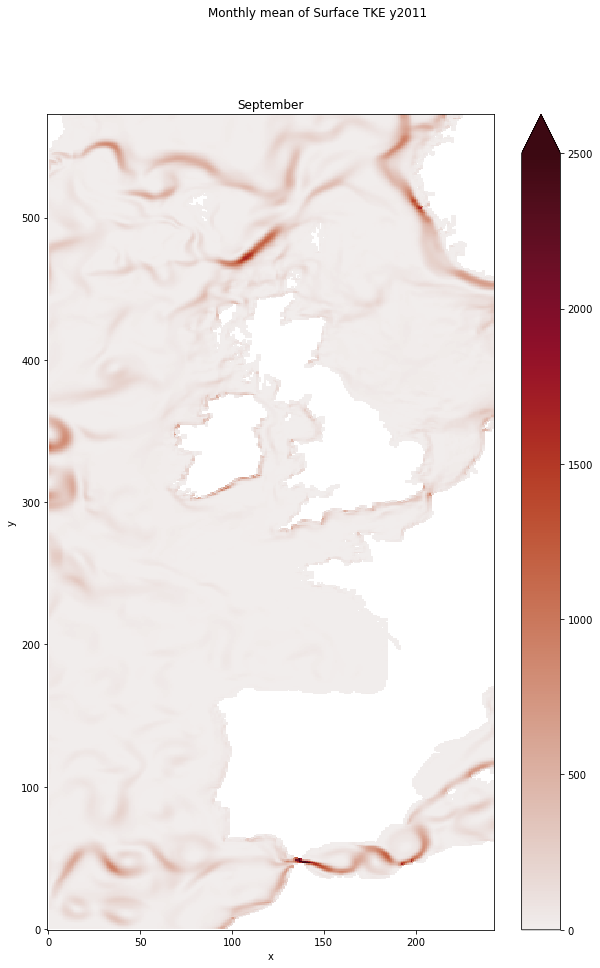

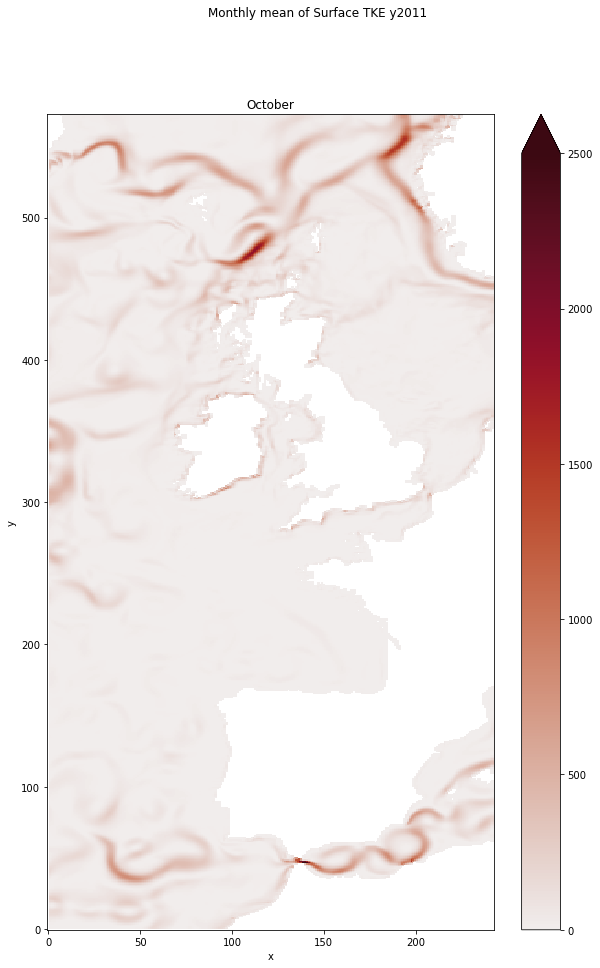

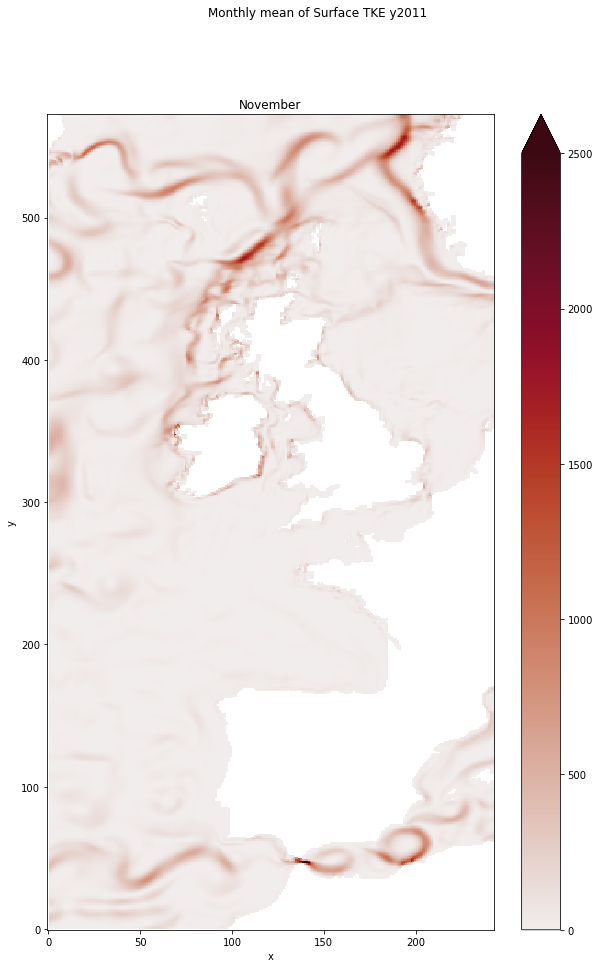

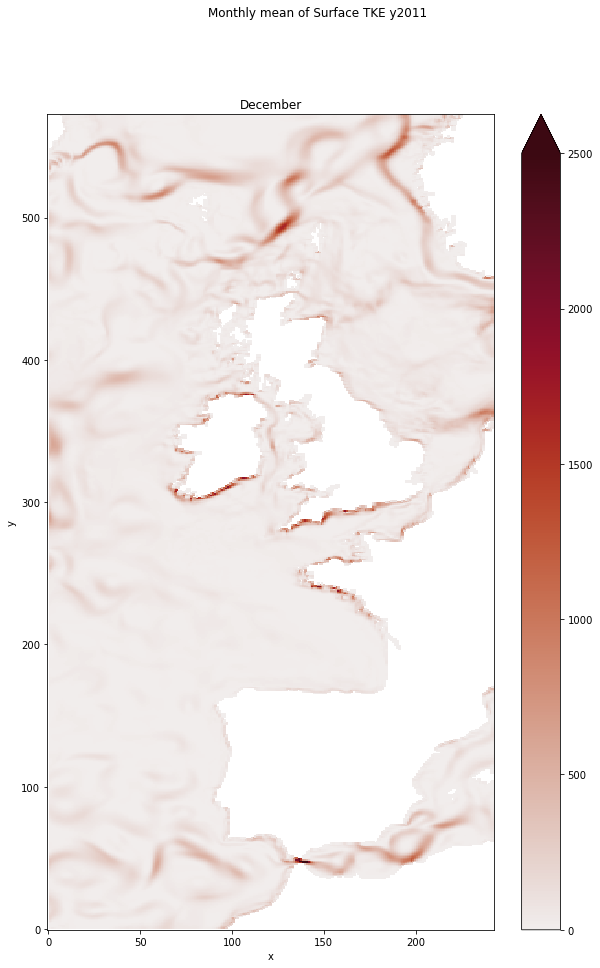

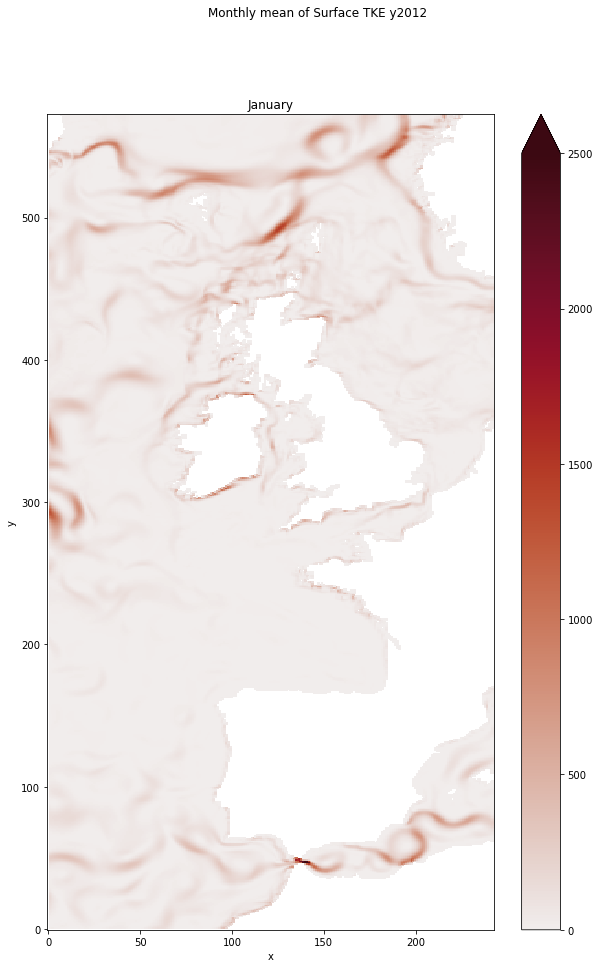

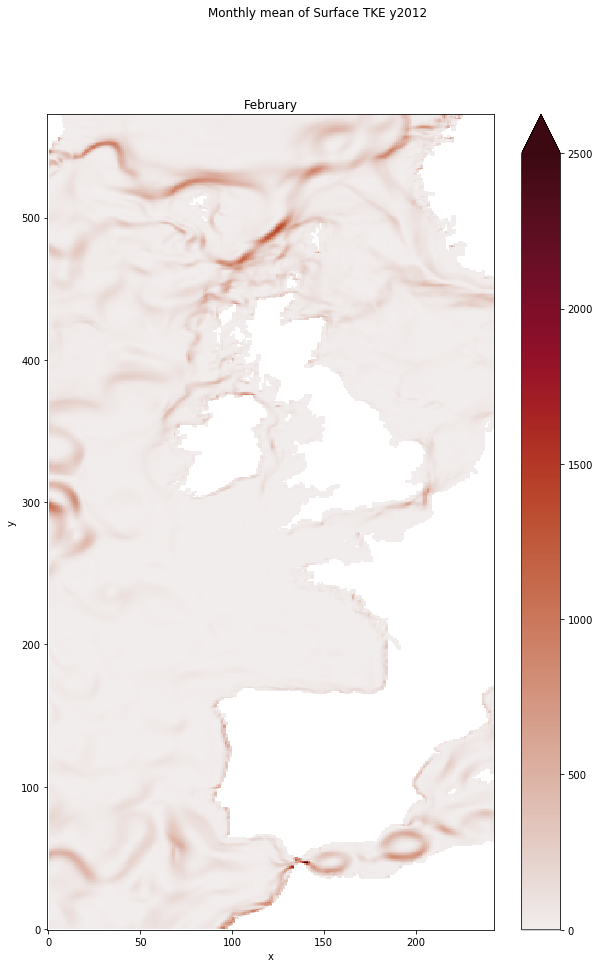

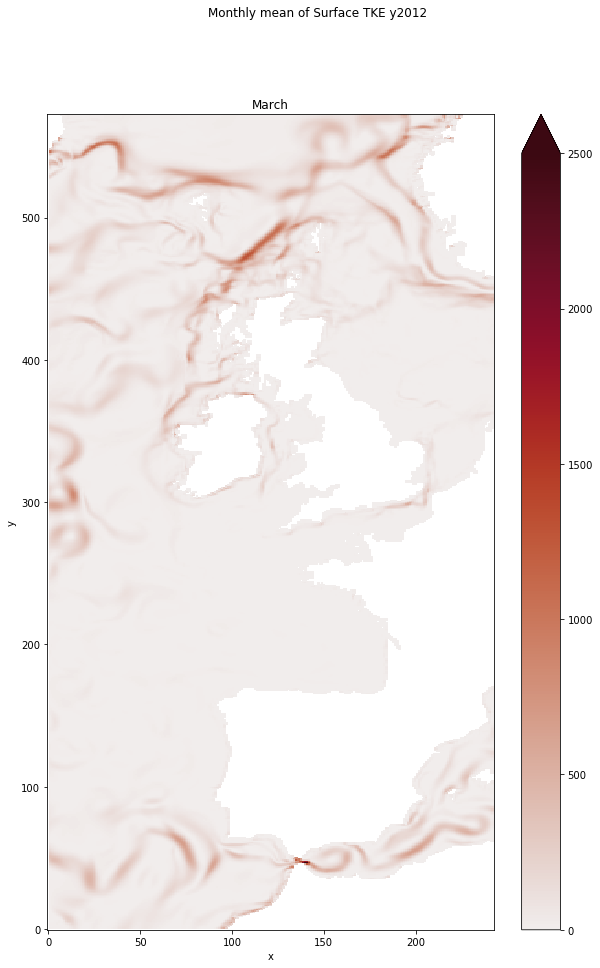

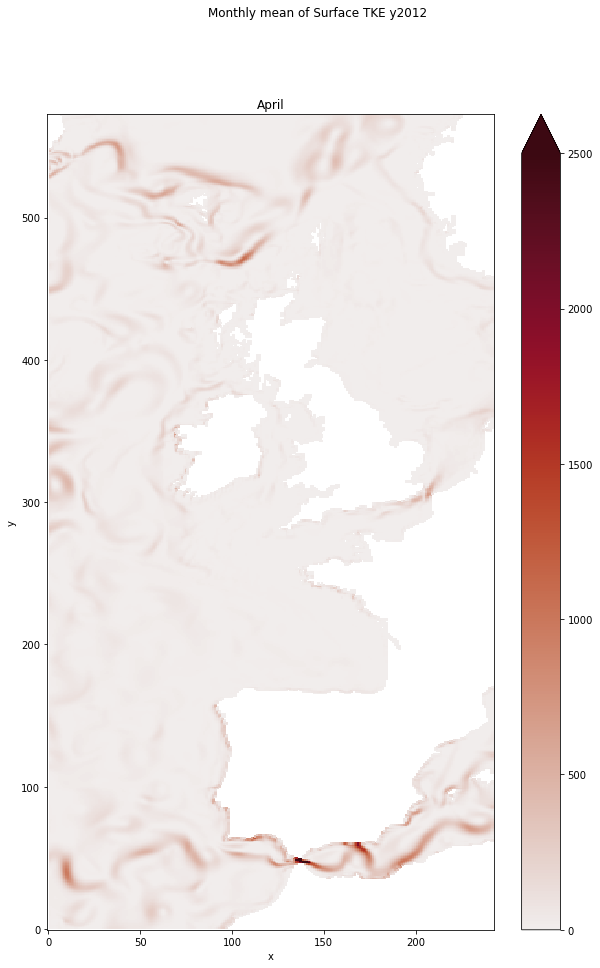

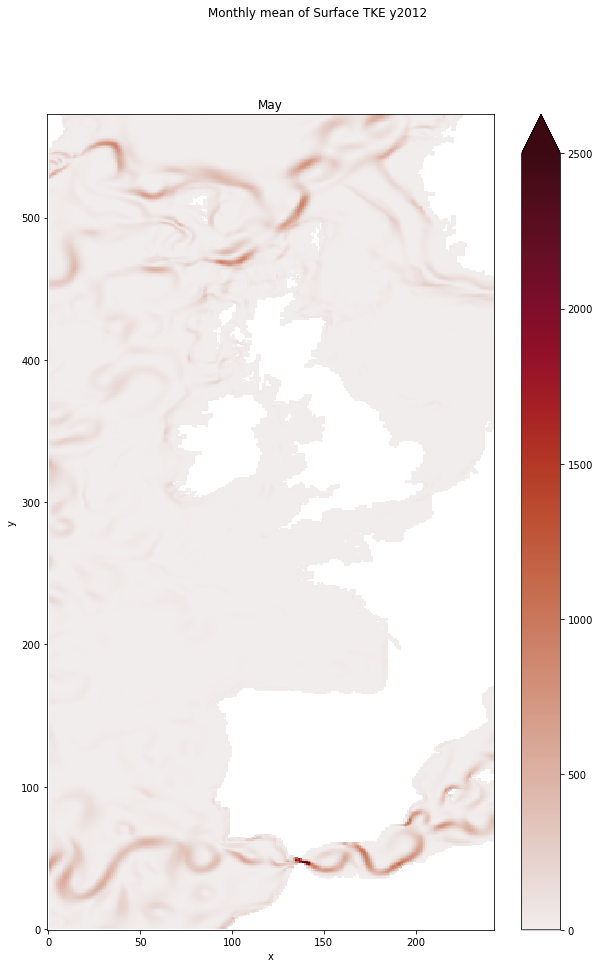

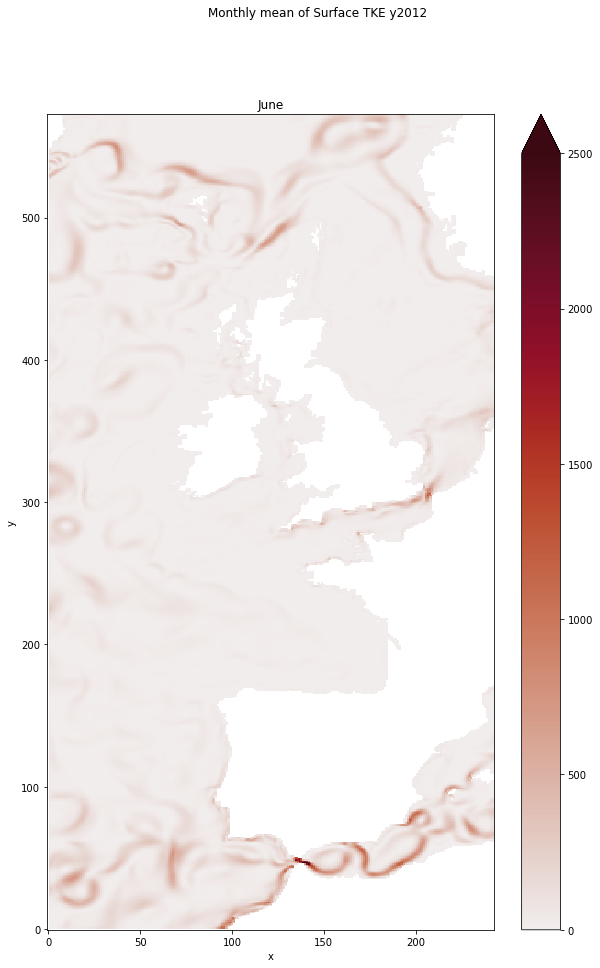

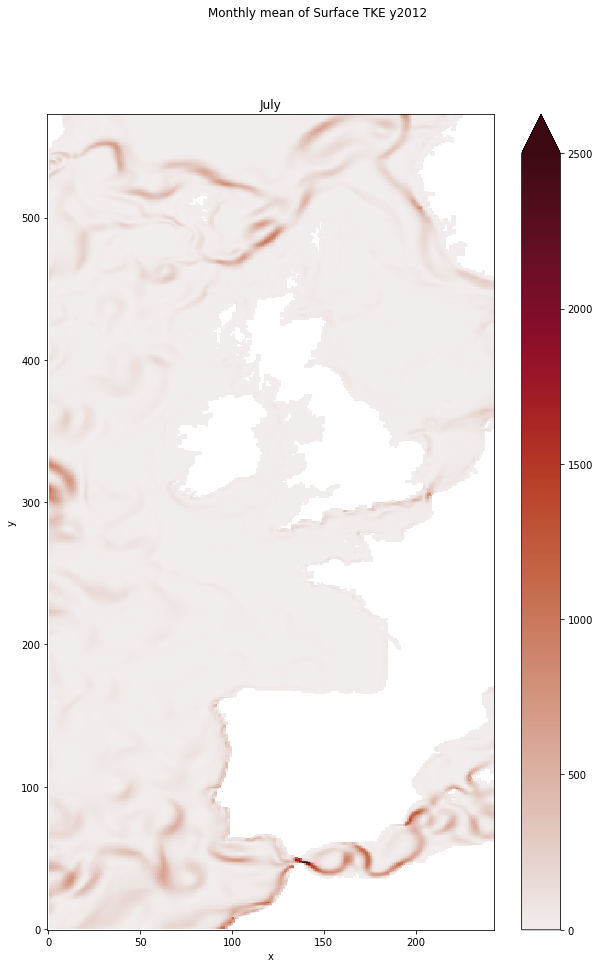

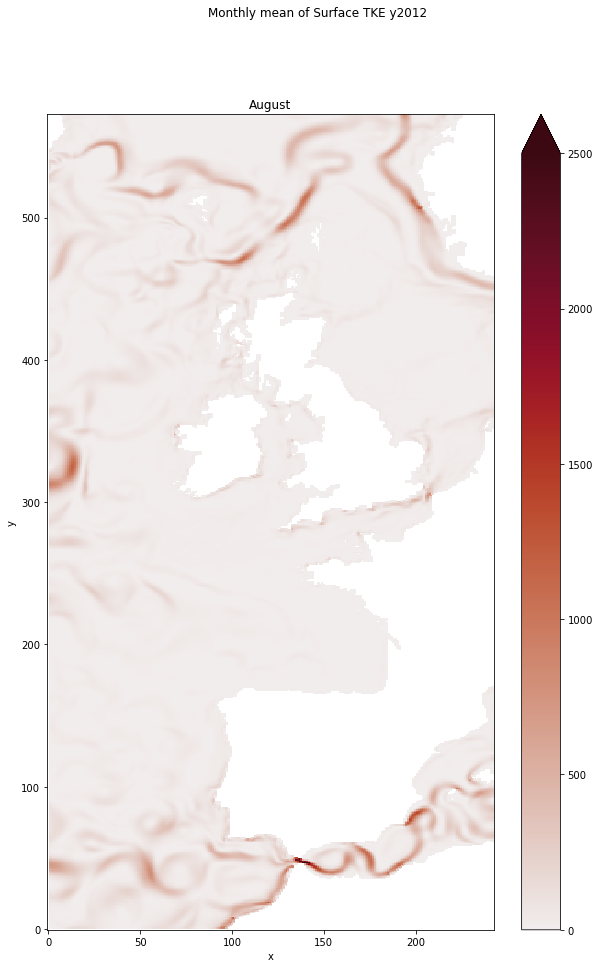

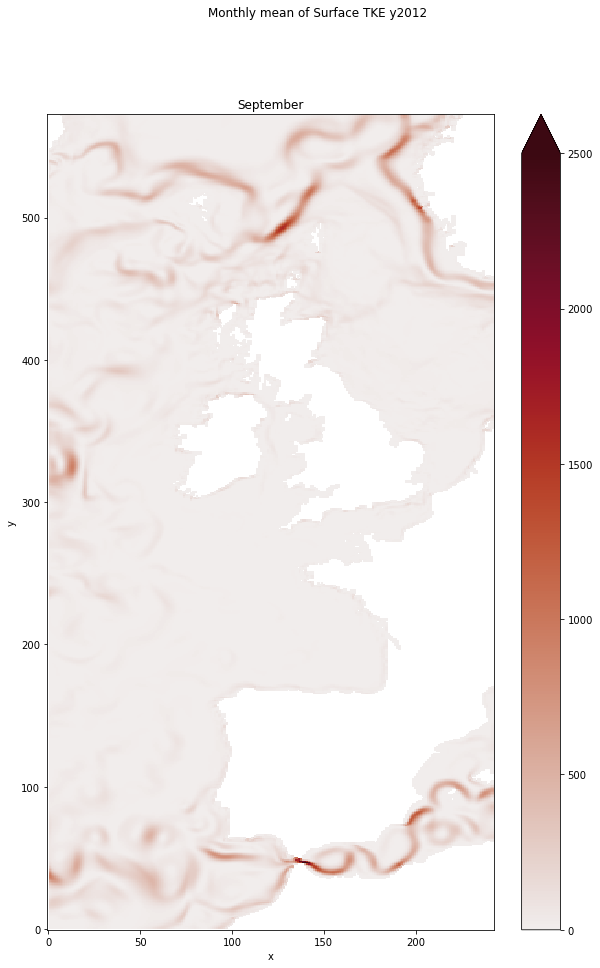

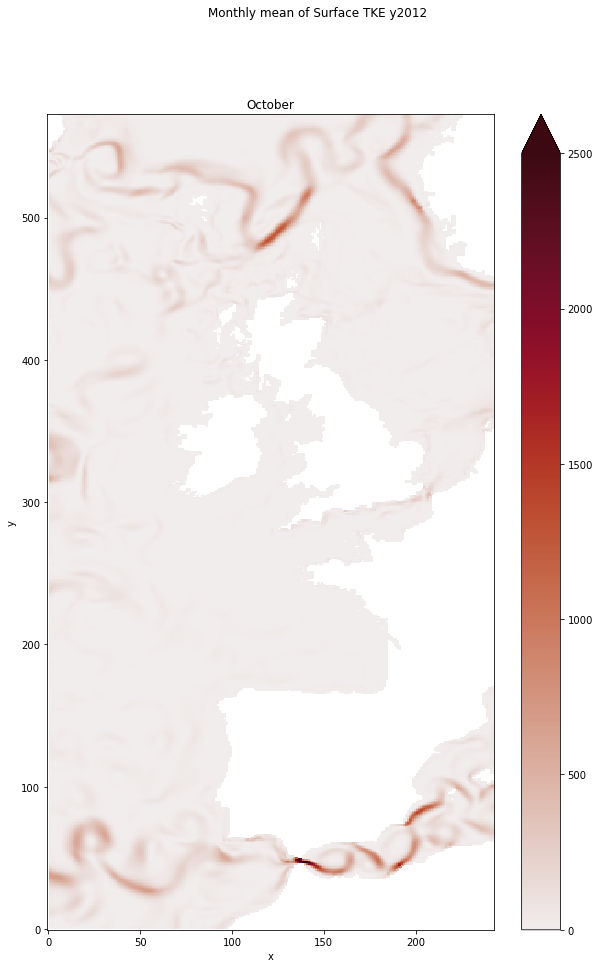

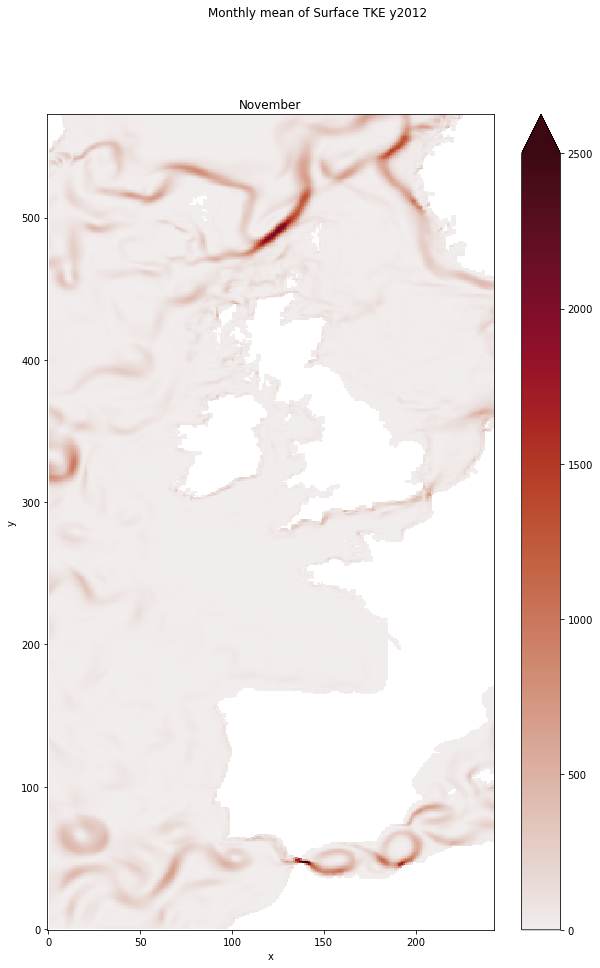

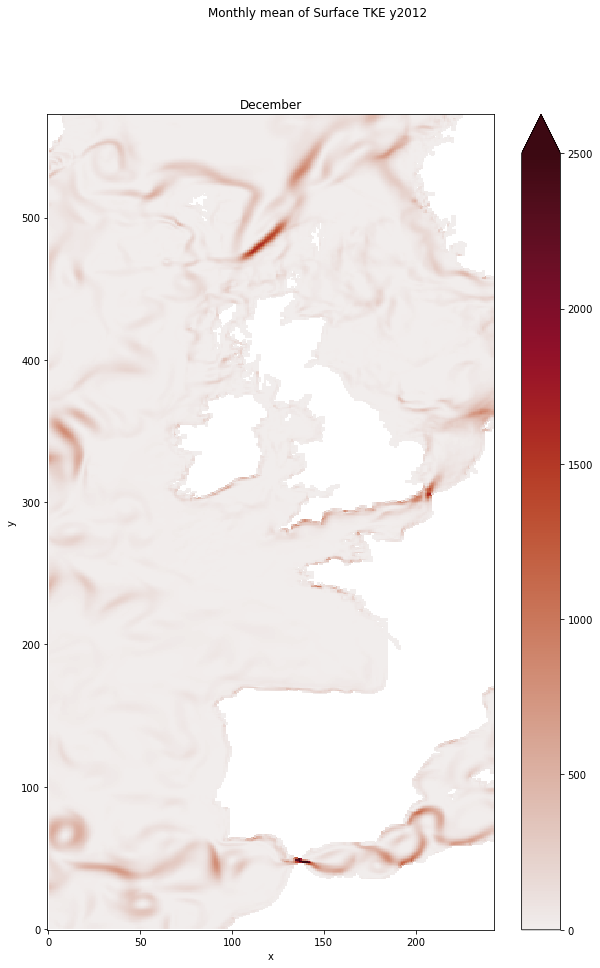

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [27]:
if plot_eke_monthly == True:
    for year in ['2011','2012']:
        print(year)
        process(year)

In [ ]:
if plot_eke_annual == True:
    datadir='/scratch/cnt0024/hmg2840/albert7a/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'+str(year)+'/'
    filesU=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridU.nc'))
    filesV=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridV.nc'))
    dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':10,'depthu':1})
    dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':10,'depthv':1})
    u=dsU.vozocrtx[:,:,651:1224,970:1213]
    v=dsV.vomecrty[:,:,651:1224,970:1213]
    mask=dsmask.tmask[0,:,651:1224,970:1213]
    u2=u*u
    v2=v*v
    u2mean=u2.mean(dim='time_counter')
    v2mean=v2.mean(dim='time_counter')
    umonth=u.groupby('time_counter.month').mean('time_counter')
    vmonth=v.groupby('time_counter.month').mean('time_counter')
    umonth2=umonth*umonth
    vmonth2=vmonth*vmonth
    tke=compute_TKE(umonth2,vmonth2)
    plot_one_year(10000*tke.mean(dim='month'),mask[0],0,2500,'cmo.amp','Surface TKE y'+year,'tke_surf',year)
